In [81]:
import findspark
import pyspark


In [82]:
import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")

In [83]:
import os
os.getcwd()


'/home/jovyan'

In [84]:
from pyspark.sql import SparkSession
from pyspark import SparkContext

In [85]:
spark = SparkSession \
    .builder \
    .appName("Pysparkexample") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [6]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.databricks:spark-xml_2.11:0.4.1 pyspark-shell'

In [7]:
sc = pyspark.SparkContext
#sc.addFile(path)


In [8]:
df_load = spark.read.csv('hdfs://192.168.122.206:8020/data/vol/depart/*.csv',header='true')

In [9]:
df_load.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- aircraft_aircrafttype_iatacode: string (nullable = true)
 |-- aircraft_aircrafttype_icaocode: string (nullable = true)
 |-- aircraft_aircrafttype_modelname: string (nullable = true)
 |-- airlines_airline_iatacode: string (nullable = true)
 |-- airlines_airline_icaocode: string (nullable = true)
 |-- airlines_airline_name: string (nullable = true)
 |-- airlines_operator_iatacode: string (nullable = true)
 |-- airlines_operator_icaocode: string (nullable = true)
 |-- airlines_operator_name: string (nullable = true)
 |-- airportresources_boarding_departurelounge: string (nullable = true)
 |-- airportresources_boarding_gates: string (nullable = true)
 |-- airportresources_checkin_checkinarea: string (nullable = true)
 |-- airportresources_checkin_desks: string (nullable = true)
 |-- airportresources_terminal: string (nullable = true)
 |-- airports_destination_iatacode: string (nullable = true)
 |-- airports_destination_icaocode: string (nullable

In [10]:
df_load.select("countrytype_description").distinct().show()

+-----------------------+
|countrytype_description|
+-----------------------+
|        UE Non Schengen|
|          International|
|               National|
|               Schengen|
+-----------------------+



In [11]:
df=df_load.orderBy('last_update_fme', ascending = False).dropDuplicates(['aircraft_aircrafttype_iatacode','timestamps_eobt','airports_next_name'])

In [12]:
df_load_meteo = spark.read.csv('hdfs://192.168.122.206:8020/data/meteo/*.csv')

In [13]:
df_load_meteo.show(10000)

+----+------+------+---+-----+------+---+-----+-----+---+-----+-----+--------------------+-----+-------+----------+
| _c0|   _c1|   _c2|_c3|  _c4|   _c5|_c6|  _c7|  _c8|_c9| _c10| _c11|                _c12| _c13|   _c14|      _c15|
+----+------+------+---+-----+------+---+-----+-----+---+-----+-----+--------------------+-----+-------+----------+
|null|120000|103300|340|  5.1|278.96| 75|10000|   20|0.0|0.0.1|0.0.2|Arrondissement de...|45.75|   4.58|1580892780|
|   0|120000|102900|  0|  0.5|285.15| 81| 7000|   40|0.0|  0.0|  0.0|             Algiers|36.75|   3.04|1580892895|
|   1|120000|102300|340|  8.7|286.15| 62|10000|   40|0.0|  0.0|  0.0|              Annaba| 36.9|   7.77|1580893061|
|   2|120000|102500|320|  4.6|280.15| 70|10000|   75|0.0|  0.0|  0.0|               Batna|35.56|   6.17|1580892997|
|   3|120000|102100|330|  7.7|290.15| 29|10000|   20|0.0|  0.0|  0.0|              Biskra|34.85|   5.73|1580893061|
|   4|120000|102700|200|  1.5|282.74| 71| 7000|   75|0.0|  0.0|  0.0|   

In [14]:
df_load_meteo=df_load_meteo.withColumnRenamed("_c0","index").withColumnRenamed("_c1","numero").withColumnRenamed("_c2","pression").withColumnRenamed("_c3","direction_de_vent").withColumnRenamed("_c4","vitesse_de_vent").withColumnRenamed("_c5","temperature").withColumnRenamed("_c6","humidité").withColumnRenamed("_c7","visibilité").withColumnRenamed("_c8","nebulosite").withColumnRenamed("_c9","hauteur_neige").withColumnRenamed("_c10","precipitations_1").withColumnRenamed("_c11","precipitations_3").withColumnRenamed("_c12","nom").withColumnRenamed("_c13","longitude").withColumnRenamed("_c14","latitude").withColumnRenamed("_c15","timestamp") 

In [15]:
df_load_meteo=df_load_meteo.drop(df_load_meteo.index)

In [16]:
from pyspark.sql.functions import from_unixtime,from_utc_timestamp
func =  lambda x:from_unixtime(x, format='yyyy-MM-dd HH:mm:ss')
df_load_meteo=df_load_meteo.withColumn('timestamp',func(df_load_meteo['timestamp']))

In [17]:
df_load_meteo.filter(df_load_meteo.timestamp == '2020-01-20 14:38:29').show(10)

+------+--------+-----------------+---------------+-----------+--------+----------+----------+-------------+----------------+----------------+--------------------+---------+--------+-------------------+
|numero|pression|direction_de_vent|vitesse_de_vent|temperature|humidité|visibilité|nebulosite|hauteur_neige|precipitations_1|precipitations_3|                 nom|longitude|latitude|          timestamp|
+------+--------+-----------------+---------------+-----------+--------+----------+----------+-------------+----------------+----------------+--------------------+---------+--------+-------------------+
|120000|  103700|              350|            2.1|     278.67|      48|     10000|         1|          0.0|           0.0.1|           0.0.2|Arrondissement de...|    45.75|    4.58|2020-01-20 14:38:29|
|120000|  103700|              350|            2.1|     278.67|      48|     10000|         1|          0.0|             0.0|             0.0|Arrondissement de...|    45.75|    4.58|2020-0

In [18]:
df_load_meteo['timestamp'][0]

Column<b'timestamp[0]'>

In [19]:
df_load_meteo.select('nom').first()

Row(nom='Arrondissement de Lyon')

In [20]:
df_load_meteo=df_load_meteo.dropDuplicates(['nom','timestamp'])

In [21]:
import pyspark.sql.functions as F
df_meteo=df_load_meteo.withColumn("timestamp_30_before", df_load_meteo.timestamp - F.expr('INTERVAL 30 MINUTES') )
df_meteo=df_meteo.withColumn("timestamp_30_after", df_load_meteo.timestamp + F.expr('INTERVAL 30 MINUTES') )

In [22]:
df_Lyon_meteo=df_meteo.filter("nom = 'Arrondissement de Lyon'")

In [23]:
joined_df = df.join(df_Lyon_meteo, [df.timestamps_eobt < df_Lyon_meteo.timestamp_30_after,df_Lyon_meteo.timestamp_30_before < df.timestamps_eobt], how='inner')

In [25]:
joined_df=joined_df.orderBy('timestamps_eobt').select(['aircraft_aircrafttype_icaocode','flightnumbers_icaoflightnumber', 'airportresources_terminal','airports_destination_name','airlines_airline_name','airlines_operator_icaocode','airlines_airline_icaocode','countrytype_code','timestamps_sobt','timestamps_eobt','pression', 'direction_de_vent',
       'vitesse_de_vent', 'temperature', 'humidité', 'visibilité',
       'nebulosite', 'hauteur_neige'])

In [26]:
def to_part_of_day(x):
    if x < 12:
        return "morning"
    elif x < 18:
        return "afternoon"
    else:
        return "evening"
def change(row):
    row['part_of_day']=to_part_of_day(row['timestamps_sobt'].hour)
    if((row['timestamps_eobt']-row['timestamps_sobt']).seconds/60 > 0):
        row['delay']=int((row['timestamps_eobt']-row['timestamps_sobt']).seconds/60)
    else :
        row['delay']=0
    if(int(row['delay'])<=15):
        row['delayLabel']='[0-15]'
    elif(15<int(row['delay'])<=30) :
        row['delayLabel']='[15-30]'
    elif(30<int(row['delay'])<=45) :
        row['delayLabel']='[30-45]'
    elif(45<int(row['delay'])<=60) :
        row['delayLabel']='[45-60]'
    elif(60<int(row['delay'])<=75) :
        row['delayLabel']='[60-75]'
    elif(75<int(row['delay'])<=90) :
        row['delayLabel']='[75-90]'
    elif(105<int(row['delay'])<=120) :
        row['delayLabel']='[105-120]'
    elif(120<int(row['delay'])<=135) :
        row['delayLabel']='[120-135]'
    elif(90<int(row['delay'])<=105) :
        row['delayLabel']='[90-105]'
    elif(150<int(row['delay'])<=165) :
        row['delayLabel']='[150-165]'
    elif(165<int(row['delay'])<=180) :
        row['delayLabel']='[165-180]'
    elif(180<int(row['delay'])<=195) :
        row['delayLabel']='[180-195]'
    elif(210<int(row['delay'])<=225) :
        row['delayLabel']='[210-225]'
    elif(225<int(row['delay'])<=240) :
        row['delayLabel']='[225-240]'
    elif(240<int(row['delay'])<=255) :
        row['delayLabel']='[240-255]'
    elif(255<int(row['delay'])<=270) :
        row['delayLabel']='[255-270]'
    elif(270<int(row['delay'])<=285) :
        row['delayLabel']='[270-285]'
    elif(285<int(row['delay'])<=300) :
        row['delayLabel']='[285-300]'
    elif(195<int(row['delay'])<=210) :
        row['delayLabel']='[195-210]'
    else :
        row['delayLabel']='more then 4 hours'
    
    return row
            

In [27]:
def changethedate(s):
    tab=s.split("-")
    if len(tab[1])==1:
        tab[1]='0'+tab[1]
    s=tab[0]+'-'+tab[1]+'-'+tab[2]
    return s

import json
import requests
import time
import pandas as pd
url="https://pomber.github.io/covid19/timeseries.json"
            #print(url)
response = requests.get(url)
data_json=response.json()

dd=[]
for d in data_json:
        for l in data_json[d]:
                l['pays']=d
                dd.append(l)

covid_df= spark.createDataFrame(dd)
from pyspark.sql.functions import col, udf
from pyspark.sql.types import StringType
func =  udf (lambda x: changethedate(x),StringType())
covid_df=covid_df.withColumn('new_date',func(covid_df['date']))
from pyspark.sql.types import DateType
func =  udf (lambda x: datetime.datetime.strptime(x,'%Y-%m-%d'),DateType())
covid_df=covid_df.withColumn('date_obs',func(covid_df['new_date']))

#create data frame
covid_df=covid_df.select('pays','date_obs','confirmed')

In [28]:
covid_df=covid_df.filter(F.col('pays')=='France')

In [29]:
from pyspark.sql.functions import from_unixtime,from_utc_timestamp
func =  lambda x:pyspark.sql.functions.split(x, ' ')
joined_df=joined_df.withColumn('datedepart',func(joined_df['timestamps_sobt']).getItem(0))

In [30]:
df_Glob = joined_df.join(covid_df, [joined_df.datedepart==covid_df.date_obs], how='left')

In [31]:
from pyspark.sql.functions import coalesce
df_Glob=df_Glob.withColumn('date_obs', coalesce('date_obs', 'datedepart'))
df_Glob=df_Glob.na.fill({'pays': 'France', 'confirmed': 0})

In [32]:
from pyspark.sql.functions import isnan, when, count, col

df_Glob.select([count(when(isnan(c), c)).alias(c) for c in df_Glob.columns]).show()

+------------------------------+------------------------------+-------------------------+-------------------------+---------------------+--------------------------+-------------------------+----------------+---------------+---------------+--------+-----------------+---------------+-----------+--------+----------+----------+-------------+----------+----+--------+---------+
|aircraft_aircrafttype_icaocode|flightnumbers_icaoflightnumber|airportresources_terminal|airports_destination_name|airlines_airline_name|airlines_operator_icaocode|airlines_airline_icaocode|countrytype_code|timestamps_sobt|timestamps_eobt|pression|direction_de_vent|vitesse_de_vent|temperature|humidité|visibilité|nebulosite|hauteur_neige|datedepart|pays|date_obs|confirmed|
+------------------------------+------------------------------+-------------------------+-------------------------+---------------------+--------------------------+-------------------------+----------------+---------------+---------------+--------+--

In [33]:
pdf=df_Glob.toPandas()

In [34]:
pdf

aircraft_aircrafttype_icaocode flightnumbers_icaoflightnumber  \
0                               A320                       EJU4459    
1                               B737                       KLM1416    
2                               A320                       EJU4353    
3                               A319                       EJU4371    
4                               A320                       AFR7643    
...                              ...                            ...   
17551                           AT45                       CLG076     
17552                           B738                       DAH1139    
17553                           B748                       DAH1037    
17554                           B738                       DAH1461    
17555                           B738                       DAH1033    

      airportresources_terminal airports_destination_name  \
0                         T1                     Tenerife   
1                         T2                    Amsterdam   
2                         T1                       Nantes   
3                         T1            Berlin-Schonefeld   
4                         T2           Paris C. De Gaulle   
...                         ...                       ...   
17551                     T2                      Limoges   
17552                     T1                       Bejaia   
17553                     T1                        Alger   
17554                     T1                  Constantine   
17555                     T1                        Alger   

      airlines_airline_name airlines_operator_icaocode  \
0           Easy Jet Europe                        EJU   
1                       Klm                        KLM   
2           Easy Jet Europe                        EJU   
3           Easy Jet Europe                        EJU   
4                Air France                        AFR   
...                     ...                        ...   
17551      Chalair Aviation                        CLG   
17552           Air Algerie                        DAH   
17553           Air Algerie                        DAH   
17554           Air Algerie                        DAH   
17555           Air Algerie                        DAH   

      airlines_airline_icaocode countrytype_code      timestamps_sobt  \
0                           EJU                S  2020-02-26 14:00:00   
1                           KLM                S  2020-02-26 14:10:00   
2                           EJU                N  2020-02-26 14:10:00   
3                           EJU                S  2020-02-26 14:15:00   
4                           AFR                N  2020-02-26 14:15:00   
...                         ...              ...                  ...   
17551                       CLG                N  2020-04-05 20:10:00   
17552                       DAH                I  2020-05-01 12:50:00   
17553                       DAH                I  2020-05-01 13:35:00   
17554                       DAH                I  2020-05-01 18:20:00   
17555                       DAH                I  2020-05-01 20:20:00   

           timestamps_eobt pression direction_de_vent vitesse_de_vent  \
0      2020-02-26 14:00:00   101100               310            10.8   
1      2020-02-26 14:10:00   101100               310            10.8   
2      2020-02-26 14:12:00   101100               310            10.8   
3      2020-02-26 14:15:00   101100               310            10.8   
4      2020-02-26 14:32:00   101200               300             9.3   
...                    ...      ...               ...             ...   
17551  2020-04-05 20:10:00   101900               170             4.6   
17552  2020-05-01 12:50:00   100800               209            2.25   
17553  2020-05-01 13:35:00   100800               209            2.25   
17554  2020-05-01 18:20:00   100800               270            3.24   
17555  2020-05-01 20:20:00   100900        

In [35]:
from datetime import datetime
pdf['timestamps_eobt'] = pdf['timestamps_eobt'].apply(lambda x: datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S"))
pdf['timestamps_sobt'] =pdf['timestamps_sobt'].apply(lambda x: datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S"))
pdf=pdf.apply(lambda x:change(x),axis=1)

In [36]:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}


In [37]:
a=pdf['airlines_airline_name']!='A SUPPRIMER'
global_stats = pdf['delay'][pdf['airlines_airline_name']!='A SUPPRIMER'].groupby(pdf['airlines_airline_icaocode']).apply(get_stats).unstack()
global_stats = global_stats.sort_values('count')
global_stats

min     max   count       mean
airlines_airline_icaocode                                
XXX                        0.0     0.0     1.0   0.000000
None                       0.0     0.0     1.0   0.000000
OHY                        0.0     0.0     1.0   0.000000
FHY                        0.0     0.0     1.0   0.000000
RBG                        0.0     0.0     1.0   0.000000
...                        ...     ...     ...        ...
BAW                        0.0   124.0   581.0  11.820998
DAH                        0.0   475.0   889.0  30.133858
DLH                        0.0   132.0  1054.0   5.759013
EJU                        0.0   260.0  2774.0  16.969358
AFR                        0.0  1438.0  5992.0  11.650033

[74 rows x 4 columns]

In [38]:
abbr_companies=pdf[['airlines_airline_name','airlines_airline_icaocode']][pdf['airlines_airline_name']!='A SUPPRIMER'].drop_duplicates()
abbr_companies = abbr_companies.set_index('airlines_airline_icaocode')['airlines_airline_name'].to_dict()

In [39]:
abbr_companies

{'EJU': 'Easy Jet Europe',
 'KLM': 'Klm',
 'AFR': 'Air France',
 'DLH': 'Lufthansa',
 'EIN': 'Aer Lingus',
 'TVF': 'Transavia France',
 'BAW': 'British Airways',
 'EZY': 'Easyjet ',
 'CCM': 'Air corsica',
 'DAH': 'Air Algerie',
 'TJT': 'Twinjet',
 'THY': 'Turkish',
 'TAP': 'Tap Air Portugal',
 'EWG': 'Eurowings',
 'BEL': 'Brussels Airlines',
 'IBE': 'Iberia Airlines',
 'RAM': 'Royal Air Maroc',
 'AUA': 'Austrian Airlines',
 'CLG': 'Chalair Aviation',
 'UAE': 'Emirates Airlines',
 'ELF': 'FLY GR8',
 'ENT': 'Enter Air',
 'LMU': 'Almasria universal airlines',
 'TAR': 'Tunis Air',
 'LAV': 'Alba Star',
 'LBT': 'Nouvelair',
 'ACA': 'Air Canada',
 'VLG': 'Vueling Airlines S.A.',
 'PGT': 'Pegasus Airlines',
 'FHM': 'Free bird europe',
 'IBS': 'Iberia Express',
 'RYR': 'Ryanair',
 'SCW': 'Braathens Regional Aviation AB',
 'MAC': 'Air Arabia',
 'AFL': 'Aeroflot',
 'TOM': 'Thomsonfly.Com',
 'IBK': 'Norwegian',
 'AWC': 'Titan Airways',
 'AMC': 'Air Malta',
 'TVS': 'Travel Service Airlines',
 'VOE'

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


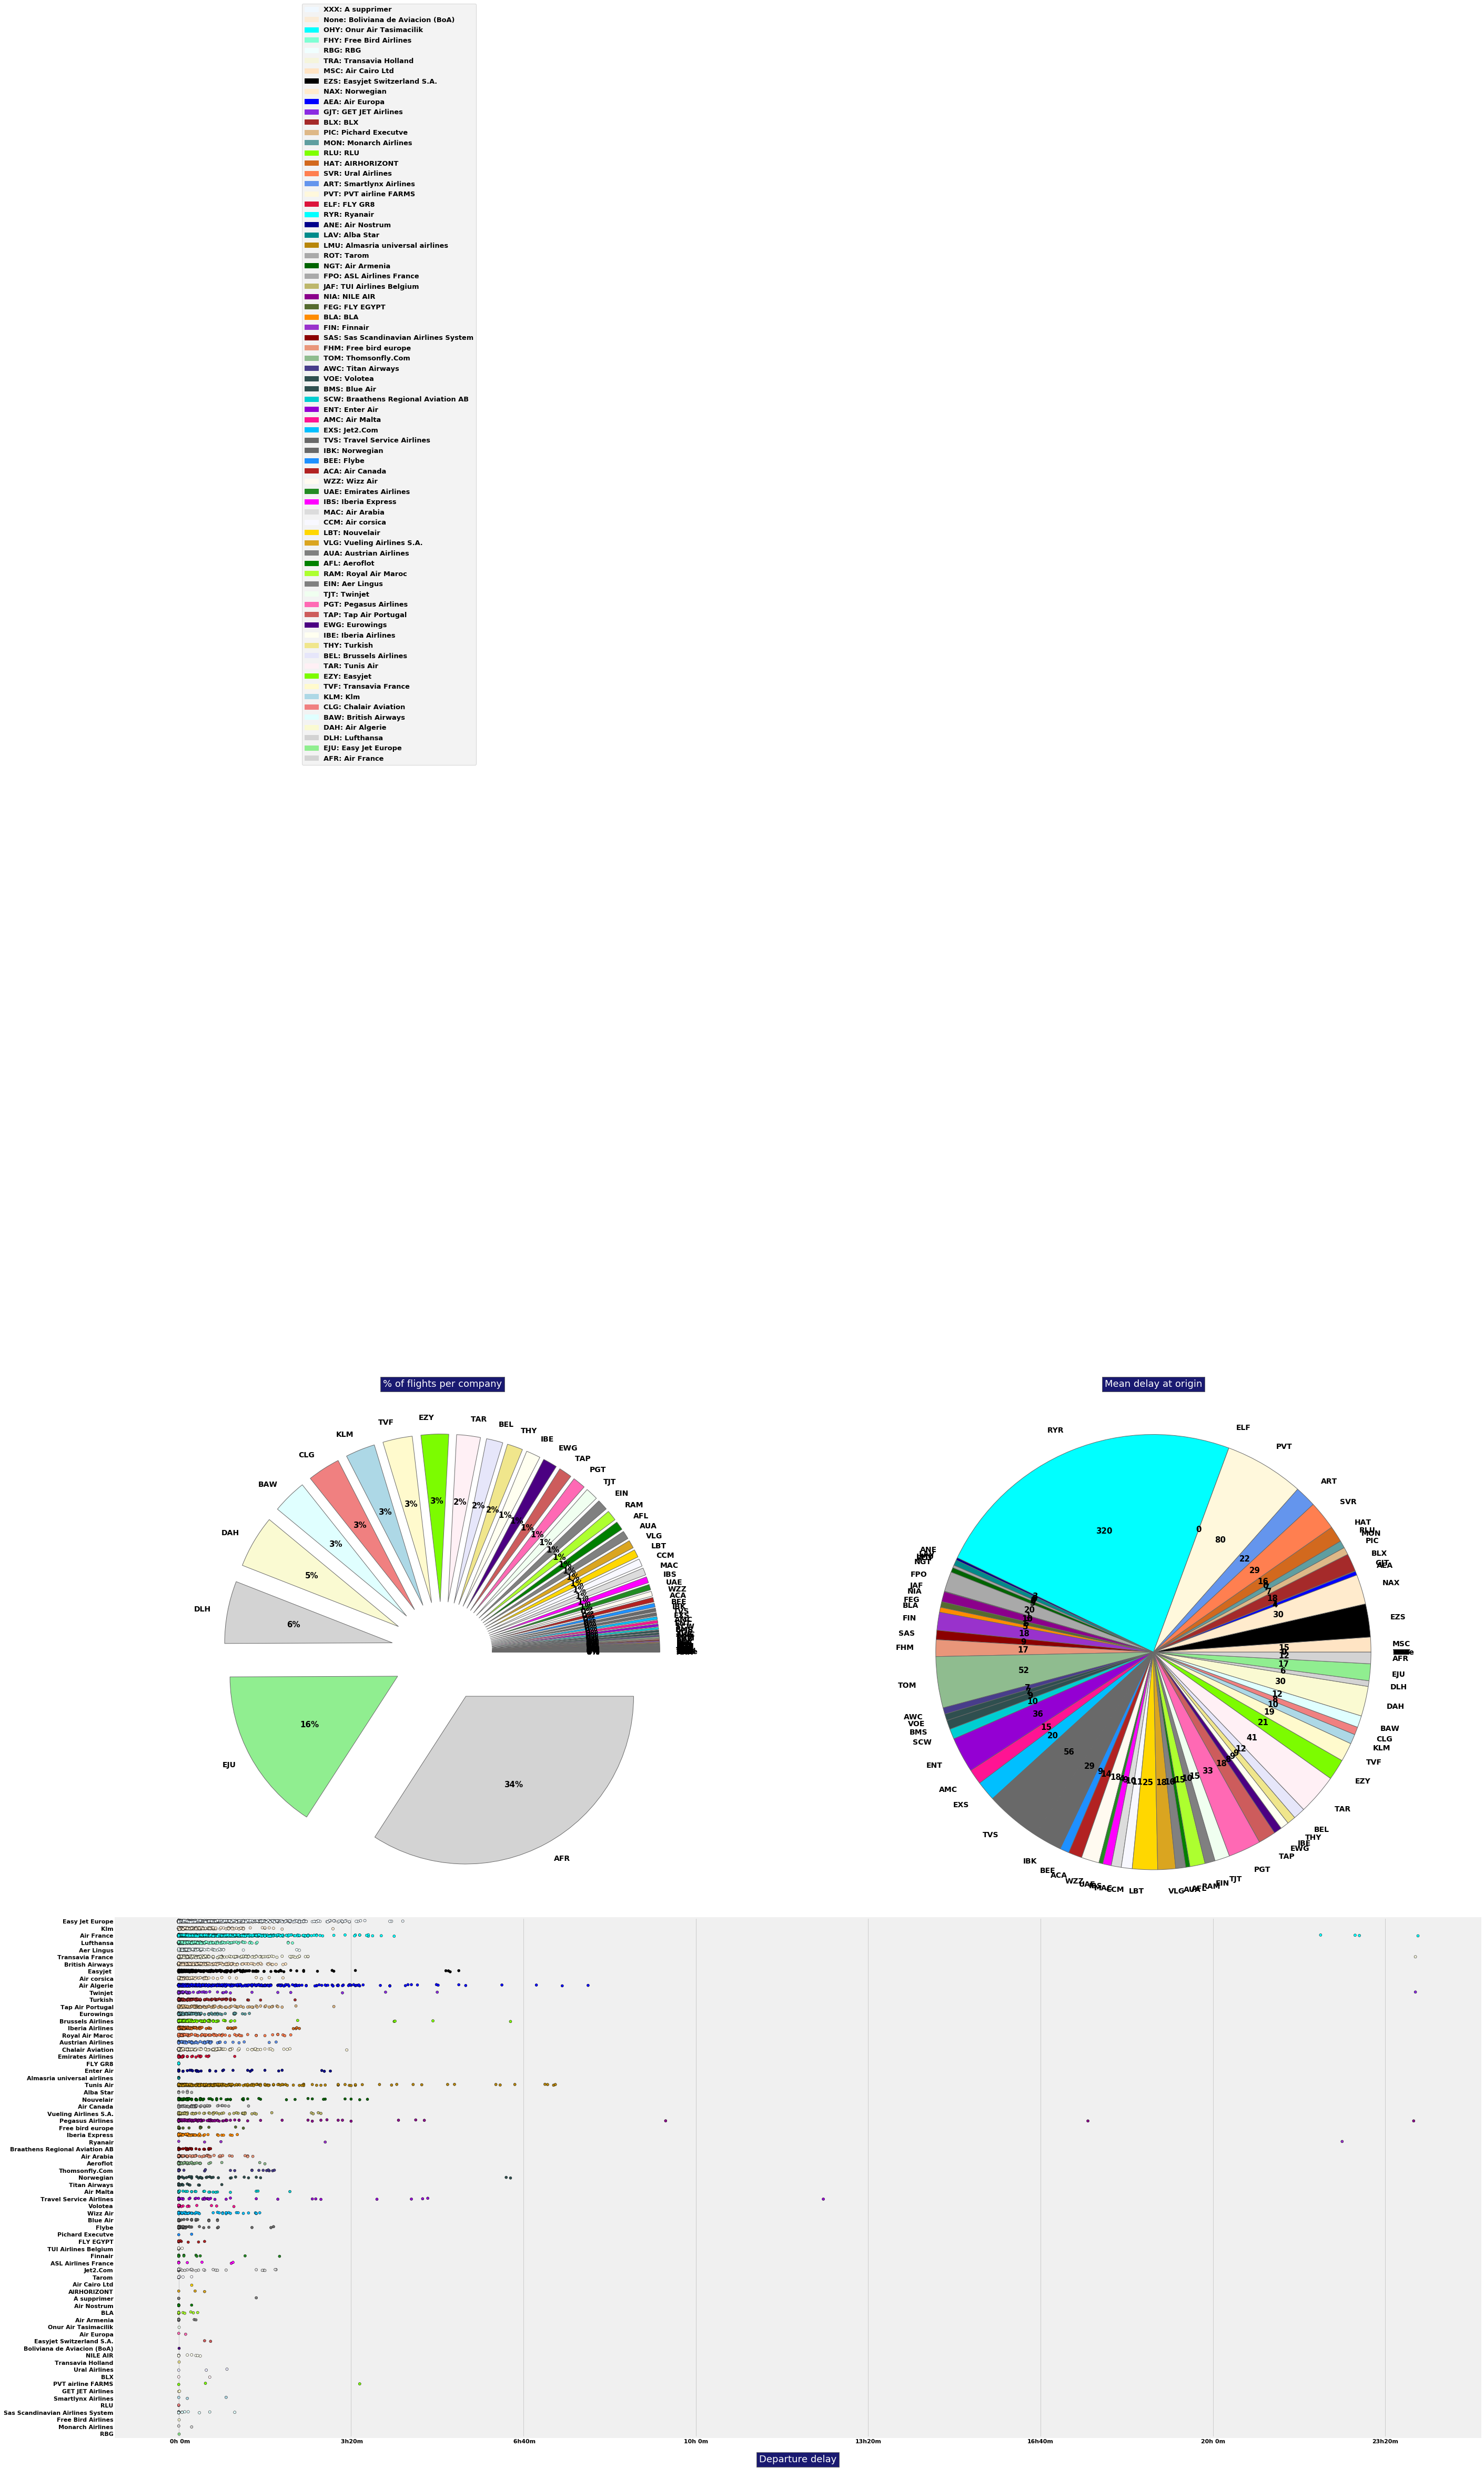

In [40]:
font = {'family' : 'normal', 'weight' : 'bold', 'size'   : 15}
mpl.rc('font', **font)
import matplotlib.patches as mpatches
#__________________________________________________________________
# I extract a subset of columns and redefine the airlines labeling 
df2 = pdf.loc[:, ['airlines_airline_icaocode', 'delay']]
df2['airlines_airline_icaocode'] = df2['airlines_airline_icaocode'].replace(abbr_companies)
#________________________________________________________________________
colors = [*mpl.colors.CSS4_COLORS]
#___________________________________
fig = plt.figure(1, figsize=(40,50))
gs=GridSpec(2,2)             
ax1=fig.add_subplot(gs[0,0]) 
ax2=fig.add_subplot(gs[0,1]) 
ax3=fig.add_subplot(gs[1,:]) 
#------------------------------
# Pie chart nº1: nb of flights
#------------------------------
labels = [s for s in  global_stats.index]
sizes  = global_stats['count'].values
explode = [0.3 if sizes[i] < 20000 else 0.0 for i in range(len(abbr_companies))]
patches, texts, autotexts = ax1.pie(sizes, explode = explode,
                                labels=labels, colors = colors,  autopct='%1.0f%%',
                                shadow=False, startangle=0)
for i in range(len(abbr_companies)): 
    texts[i].set_fontsize(14)
ax1.axis('equal')
ax1.set_title('% of flights per company', bbox={'facecolor':'midnightblue', 'pad':5},
              color = 'w',fontsize=18)
#_______________________________________________
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(len(abbr_companies)):
    comp_handler.append(mpatches.Patch(color=colors[i],
            label = global_stats.index[i] + ': ' + abbr_companies[global_stats.index[i]]))
ax1.legend(handles=comp_handler, bbox_to_anchor=(0.2, 0.9), 
           fontsize = 13, bbox_transform=plt.gcf().transFigure)
#----------------------------------------
# Pie chart nº2: mean delay at departure
#----------------------------------------
sizes  = global_stats['mean'].values
sizes  = [max(s,0) for s in sizes]
explode = [0.0 if sizes[i] < 20000 else 0.01 for i in range(len(abbr_companies))]
patches, texts, autotexts = ax2.pie(sizes, explode = explode, labels = labels,
                                colors = colors, shadow=False, startangle=0,
                                autopct = lambda p :  '{:.0f}'.format(p * sum(sizes) / 100))
for i in range(len(abbr_companies)): 
    texts[i].set_fontsize(14)
ax2.axis('equal')
ax2.set_title('Mean delay at origin', bbox={'facecolor':'midnightblue', 'pad':5},
              color='w', fontsize=18)
#------------------------------------------------------
# striplot with all the values reported for the delays
#___________________________________________________________________
# I redefine the colors for correspondance with the pie charts

#___________________________________________________________________
ax3 = sns.stripplot(y="airlines_airline_icaocode", x="delay", size = 5, palette = colors,
                    data=df2, linewidth = 0.5,  jitter=True)
plt.setp(ax3.get_xticklabels(), fontsize=11)
plt.setp(ax3.get_yticklabels(), fontsize=11)
ax3.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])
                         for x in ax3.get_xticks()])
plt.xlabel('Departure delay', fontsize=18, bbox={'facecolor':'midnightblue', 'pad':5},
           color='w', labelpad=20)
ax3.yaxis.label.set_visible(False)
#________________________
plt.tight_layout(w_pad=3) 



In [41]:
[*mpl.colors.CSS4_COLORS]

['aliceblue',
 'antiquewhite',
 'aqua',
 'aquamarine',
 'azure',
 'beige',
 'bisque',
 'black',
 'blanchedalmond',
 'blue',
 'blueviolet',
 'brown',
 'burlywood',
 'cadetblue',
 'chartreuse',
 'chocolate',
 'coral',
 'cornflowerblue',
 'cornsilk',
 'crimson',
 'cyan',
 'darkblue',
 'darkcyan',
 'darkgoldenrod',
 'darkgray',
 'darkgreen',
 'darkgrey',
 'darkkhaki',
 'darkmagenta',
 'darkolivegreen',
 'darkorange',
 'darkorchid',
 'darkred',
 'darksalmon',
 'darkseagreen',
 'darkslateblue',
 'darkslategray',
 'darkslategrey',
 'darkturquoise',
 'darkviolet',
 'deeppink',
 'deepskyblue',
 'dimgray',
 'dimgrey',
 'dodgerblue',
 'firebrick',
 'floralwhite',
 'forestgreen',
 'fuchsia',
 'gainsboro',
 'ghostwhite',
 'gold',
 'goldenrod',
 'gray',
 'green',
 'greenyellow',
 'grey',
 'honeydew',
 'hotpink',
 'indianred',
 'indigo',
 'ivory',
 'khaki',
 'lavender',
 'lavenderblush',
 'lawngreen',
 'lemonchiffon',
 'lightblue',
 'lightcoral',
 'lightcyan',
 'lightgoldenrodyellow',
 'lightgray',
 

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


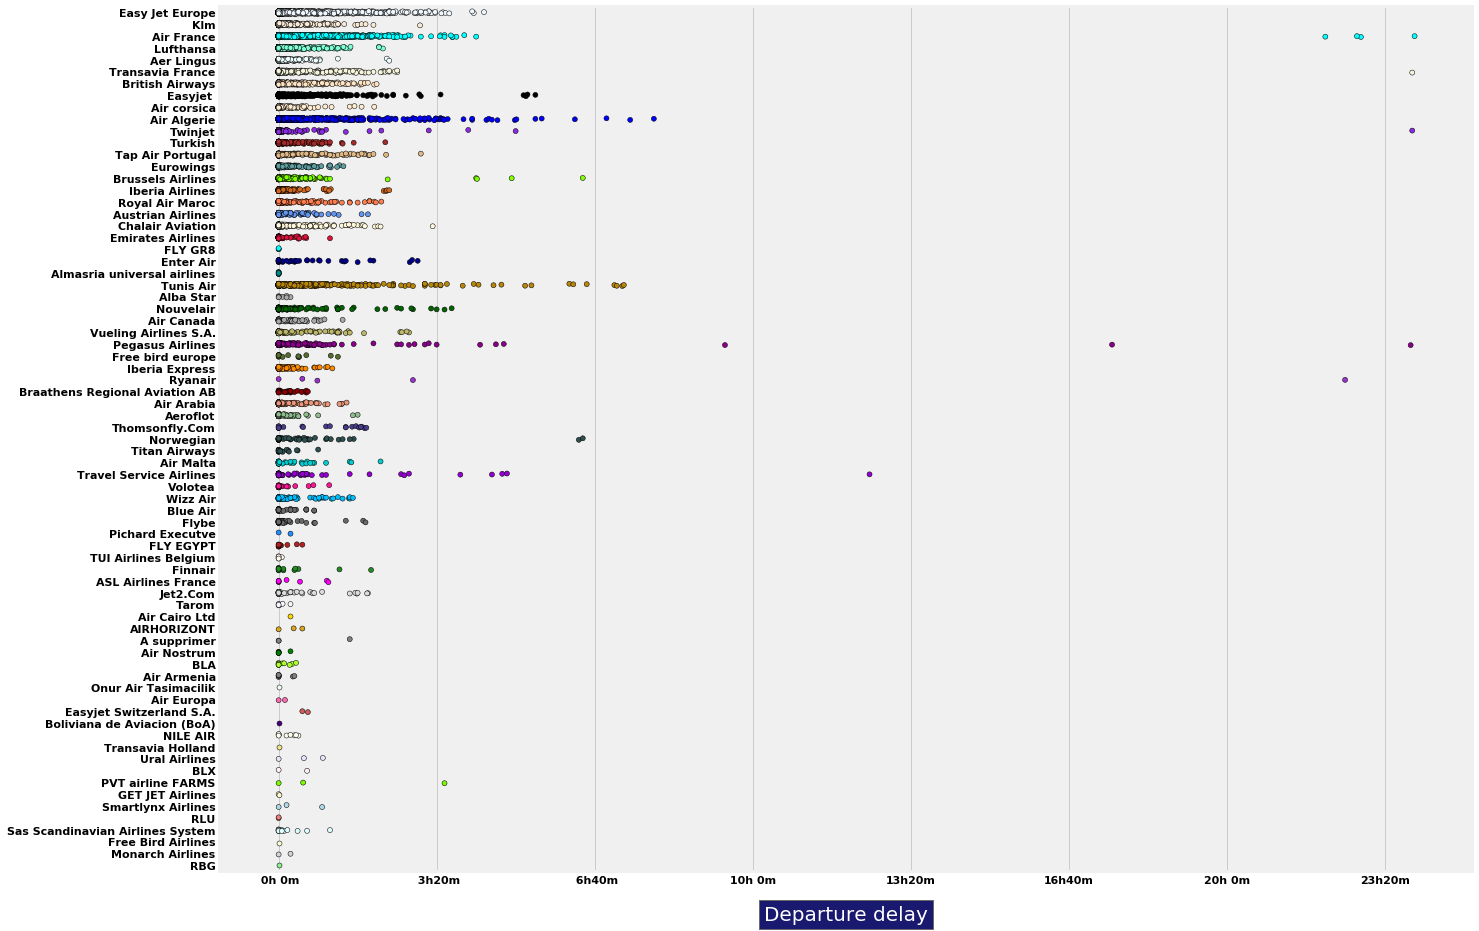

In [42]:
fig = plt.figure(1, figsize=(20,35))
ax3=fig.add_subplot(gs[1,:]) 
ax3 = sns.stripplot(y="airlines_airline_icaocode", x="delay", size = 5, palette = colors,
                    data=df2, linewidth = 0.5,  jitter=True)
plt.setp(ax3.get_xticklabels(), fontsize=11)
plt.setp(ax3.get_yticklabels(), fontsize=11)

ax3.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])
                         for x in ax3.get_xticks()])
plt.xlabel('Departure delay', fontsize=20, bbox={'facecolor':'midnightblue', 'pad':5},
           color='w', labelpad=20)
ax3.yaxis.label.set_visible(False)


In [43]:
pdf

aircraft_aircrafttype_icaocode flightnumbers_icaoflightnumber  \
0                               A320                       EJU4459    
1                               B737                       KLM1416    
2                               A320                       EJU4353    
3                               A319                       EJU4371    
4                               A320                       AFR7643    
...                              ...                            ...   
17551                           AT45                       CLG076     
17552                           B738                       DAH1139    
17553                           B748                       DAH1037    
17554                           B738                       DAH1461    
17555                           B738                       DAH1033    

      airportresources_terminal airports_destination_name  \
0                         T1                     Tenerife   
1                         T2                    Amsterdam   
2                         T1                       Nantes   
3                         T1            Berlin-Schonefeld   
4                         T2           Paris C. De Gaulle   
...                         ...                       ...   
17551                     T2                      Limoges   
17552                     T1                       Bejaia   
17553                     T1                        Alger   
17554                     T1                  Constantine   
17555                     T1                        Alger   

      airlines_airline_name airlines_operator_icaocode  \
0           Easy Jet Europe                        EJU   
1                       Klm                        KLM   
2           Easy Jet Europe                        EJU   
3           Easy Jet Europe                        EJU   
4                Air France                        AFR   
...                     ...                        ...   
17551      Chalair Aviation                        CLG   
17552           Air Algerie                        DAH   
17553           Air Algerie                        DAH   
17554           Air Algerie                        DAH   
17555           Air Algerie                        DAH   

      airlines_airline_icaocode countrytype_code     timestamps_sobt  \
0                           EJU                S 2020-02-26 14:00:00   
1                           KLM                S 2020-02-26 14:10:00   
2                           EJU                N 2020-02-26 14:10:00   
3                           EJU                S 2020-02-26 14:15:00   
4                           AFR                N 2020-02-26 14:15:00   
...                         ...              ...                 ...   
17551                       CLG                N 2020-04-05 20:10:00   
17552                       DAH                I 2020-05-01 12:50:00   
17553                       DAH                I 2020-05-01 13:35:00   
17554                       DAH                I 2020-05-01 18:20:00   
17555                       DAH                I 2020-05-01 20:20:00   

          timestamps_eobt pression direction_de_vent vitesse_de_vent  \
0     2020-02-26 14:00:00   101100               310            10.8   
1     2020-02-26 14:10:00   101100               310            10.8   
2     2020-02-26 14:12:00   101100               310            10.8   
3     2020-02-26 14:15:00   101100               310            10.8   
4     2020-02-26 14:32:00   101200               300             9.3   
...                   ...      ...               ...             ...   
17551 2020-04-05 20:10:00   101900               170             4.6   
17552 2020-05-01 12:50:00   100800               209            2.25   
17553 2020-05-01 13:35:00   100800               209            2.25   
17554 2020-05-01 18:20:00   100800               270            3.24   
17555 2020-05-01 20:20:00   100900               228            0.

In [44]:
pdf[['part_of_day','delay']].groupby('part_of_day').mean()

delay
part_of_day           
afternoon    16.202194
evening      13.393650
morning      14.553258

In [45]:
pdf

aircraft_aircrafttype_icaocode flightnumbers_icaoflightnumber  \
0                               A320                       EJU4459    
1                               B737                       KLM1416    
2                               A320                       EJU4353    
3                               A319                       EJU4371    
4                               A320                       AFR7643    
...                              ...                            ...   
17551                           AT45                       CLG076     
17552                           B738                       DAH1139    
17553                           B748                       DAH1037    
17554                           B738                       DAH1461    
17555                           B738                       DAH1033    

      airportresources_terminal airports_destination_name  \
0                         T1                     Tenerife   
1                         T2                    Amsterdam   
2                         T1                       Nantes   
3                         T1            Berlin-Schonefeld   
4                         T2           Paris C. De Gaulle   
...                         ...                       ...   
17551                     T2                      Limoges   
17552                     T1                       Bejaia   
17553                     T1                        Alger   
17554                     T1                  Constantine   
17555                     T1                        Alger   

      airlines_airline_name airlines_operator_icaocode  \
0           Easy Jet Europe                        EJU   
1                       Klm                        KLM   
2           Easy Jet Europe                        EJU   
3           Easy Jet Europe                        EJU   
4                Air France                        AFR   
...                     ...                        ...   
17551      Chalair Aviation                        CLG   
17552           Air Algerie                        DAH   
17553           Air Algerie                        DAH   
17554           Air Algerie                        DAH   
17555           Air Algerie                        DAH   

      airlines_airline_icaocode countrytype_code     timestamps_sobt  \
0                           EJU                S 2020-02-26 14:00:00   
1                           KLM                S 2020-02-26 14:10:00   
2                           EJU                N 2020-02-26 14:10:00   
3                           EJU                S 2020-02-26 14:15:00   
4                           AFR                N 2020-02-26 14:15:00   
...                         ...              ...                 ...   
17551                       CLG                N 2020-04-05 20:10:00   
17552                       DAH                I 2020-05-01 12:50:00   
17553                       DAH                I 2020-05-01 13:35:00   
17554                       DAH                I 2020-05-01 18:20:00   
17555                       DAH                I 2020-05-01 20:20:00   

          timestamps_eobt pression direction_de_vent vitesse_de_vent  \
0     2020-02-26 14:00:00   101100               310            10.8   
1     2020-02-26 14:10:00   101100               310            10.8   
2     2020-02-26 14:12:00   101100               310            10.8   
3     2020-02-26 14:15:00   101100               310            10.8   
4     2020-02-26 14:32:00   101200               300             9.3   
...                   ...      ...               ...             ...   
17551 2020-04-05 20:10:00   101900               170             4.6   
17552 2020-05-01 12:50:00   100800               209            2.25   
17553 2020-05-01 13:35:00   100800               209            2.25   
17554 2020-05-01 18:20:00   100800               270            3.24   
17555 2020-05-01 20:20:00   100900               228            0.

In [46]:
pdf[['countrytype_code','delay']].groupby('countrytype_code').min()

delay
countrytype_code       
E                     0
I                     0
N                     0
S                     0

In [47]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="specify_your_app_name_here")

from geopy.extra.rate_limiter import RateLimiter
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
pdf['location'] = pdf['airports_destination_name'].apply(geocode)

RateLimiter caught an error, retrying (0/2 tries). Called with (*('Tenerife',), **{}).
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/geopy/geocoders/base.py", line 355, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 641, in http_response
    'http', request, response, code, msg, hdrs)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 503, in _call_chain
    result = func(*args)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden

During handling of the above exception, another exception occurred:

Traceback (most rece

RateLimiter caught an error, retrying (0/2 tries). Called with (*('Nantes',), **{}).
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/geopy/geocoders/base.py", line 355, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 525, in open
    response = self._open(req, data)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 543, in _open
    '_open', req)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 503, in _call_chain
    result = func(*args)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 1362, in https_open
    context=self._context, check_hostname=self._check_hostname)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 1322, in do_open
    r = h.getresponse()
  File "/opt/conda/lib/python3.7/http/client.py", line 1344, in getresponse
    response.begin()
  File "/opt/conda/lib/python3.7/http/client.py", line 306, in begin
    version, statu

RateLimiter swallowed an error after 2 retries. Called with (*('Berlin-Schonefeld',), **{}).
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/geopy/geocoders/base.py", line 355, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 641, in http_response
    'http', request, response, code, msg, hdrs)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 503, in _call_chain
    result = func(*args)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden

During handling of the above exception, another exception occurred:

Traceback (mos

RateLimiter caught an error, retrying (1/2 tries). Called with (*('Rennes',), **{}).
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/geopy/geocoders/base.py", line 355, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 641, in http_response
    'http', request, response, code, msg, hdrs)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 503, in _call_chain
    result = func(*args)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden

During handling of the above exception, another exception occurred:

Traceback (most recent

RateLimiter caught an error, retrying (1/2 tries). Called with (*('Venise',), **{}).
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/geopy/geocoders/base.py", line 355, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 641, in http_response
    'http', request, response, code, msg, hdrs)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 503, in _call_chain
    result = func(*args)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden

During handling of the above exception, another exception occurred:

Traceback (most recent

RateLimiter caught an error, retrying (1/2 tries). Called with (*('Bordeaux',), **{}).
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/geopy/geocoders/base.py", line 355, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 641, in http_response
    'http', request, response, code, msg, hdrs)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 503, in _call_chain
    result = func(*args)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden

During handling of the above exception, another exception occurred:

Traceback (most rece

RateLimiter caught an error, retrying (1/2 tries). Called with (*('Bordeaux',), **{}).
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/geopy/geocoders/base.py", line 355, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 641, in http_response
    'http', request, response, code, msg, hdrs)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 503, in _call_chain
    result = func(*args)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden

During handling of the above exception, another exception occurred:

Traceback (most rece

RateLimiter caught an error, retrying (1/2 tries). Called with (*('Bruxelles',), **{}).
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/geopy/geocoders/base.py", line 355, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 641, in http_response
    'http', request, response, code, msg, hdrs)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 503, in _call_chain
    result = func(*args)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden

During handling of the above exception, another exception occurred:

Traceback (most rec

RateLimiter caught an error, retrying (1/2 tries). Called with (*('Marrakech',), **{}).
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/geopy/geocoders/base.py", line 355, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 641, in http_response
    'http', request, response, code, msg, hdrs)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 503, in _call_chain
    result = func(*args)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden

During handling of the above exception, another exception occurred:

Traceback (most rec

RateLimiter caught an error, retrying (1/2 tries). Called with (*('Paris C. De Gaulle',), **{}).
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/geopy/geocoders/base.py", line 355, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 641, in http_response
    'http', request, response, code, msg, hdrs)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 503, in _call_chain
    result = func(*args)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden

During handling of the above exception, another exception occurred:

Traceback 

RateLimiter caught an error, retrying (1/2 tries). Called with (*('Biarritz',), **{}).
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/geopy/geocoders/base.py", line 355, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 641, in http_response
    'http', request, response, code, msg, hdrs)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 503, in _call_chain
    result = func(*args)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden

During handling of the above exception, another exception occurred:

Traceback (most rece

RateLimiter caught an error, retrying (1/2 tries). Called with (*('Bologne',), **{}).
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/geopy/geocoders/base.py", line 355, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 641, in http_response
    'http', request, response, code, msg, hdrs)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 503, in _call_chain
    result = func(*args)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden

During handling of the above exception, another exception occurred:

Traceback (most recen

RateLimiter caught an error, retrying (1/2 tries). Called with (*('Lisbonne',), **{}).
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/geopy/geocoders/base.py", line 355, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 641, in http_response
    'http', request, response, code, msg, hdrs)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 503, in _call_chain
    result = func(*args)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden

During handling of the above exception, another exception occurred:

Traceback (most rece

RateLimiter caught an error, retrying (1/2 tries). Called with (*('Londres Luton',), **{}).
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/geopy/geocoders/base.py", line 355, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 641, in http_response
    'http', request, response, code, msg, hdrs)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 503, in _call_chain
    result = func(*args)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden

During handling of the above exception, another exception occurred:

Traceback (most

RateLimiter caught an error, retrying (1/2 tries). Called with (*('Nantes',), **{}).
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/geopy/geocoders/base.py", line 355, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 641, in http_response
    'http', request, response, code, msg, hdrs)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 503, in _call_chain
    result = func(*args)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden

During handling of the above exception, another exception occurred:

Traceback (most recent

RateLimiter caught an error, retrying (1/2 tries). Called with (*('Ajaccio',), **{}).
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/geopy/geocoders/base.py", line 355, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 641, in http_response
    'http', request, response, code, msg, hdrs)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 503, in _call_chain
    result = func(*args)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden

During handling of the above exception, another exception occurred:

Traceback (most recen

RateLimiter caught an error, retrying (1/2 tries). Called with (*('Bastia',), **{}).
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/geopy/geocoders/base.py", line 355, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 641, in http_response
    'http', request, response, code, msg, hdrs)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 503, in _call_chain
    result = func(*args)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden

During handling of the above exception, another exception occurred:

Traceback (most recent

RateLimiter caught an error, retrying (1/2 tries). Called with (*('Bologne',), **{}).
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/geopy/geocoders/base.py", line 355, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 641, in http_response
    'http', request, response, code, msg, hdrs)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 503, in _call_chain
    result = func(*args)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden

During handling of the above exception, another exception occurred:

Traceback (most recen

RateLimiter caught an error, retrying (1/2 tries). Called with (*('Ajaccio',), **{}).
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/geopy/geocoders/base.py", line 355, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 641, in http_response
    'http', request, response, code, msg, hdrs)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 503, in _call_chain
    result = func(*args)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden

During handling of the above exception, another exception occurred:

Traceback (most recen

RateLimiter caught an error, retrying (1/2 tries). Called with (*('Ajaccio',), **{}).
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/geopy/geocoders/base.py", line 355, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 641, in http_response
    'http', request, response, code, msg, hdrs)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 503, in _call_chain
    result = func(*args)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden

During handling of the above exception, another exception occurred:

Traceback (most recen

RateLimiter caught an error, retrying (1/2 tries). Called with (*('Porto',), **{}).
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/geopy/geocoders/base.py", line 355, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 641, in http_response
    'http', request, response, code, msg, hdrs)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 503, in _call_chain
    result = func(*args)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden

During handling of the above exception, another exception occurred:

Traceback (most recent 

RateLimiter caught an error, retrying (1/2 tries). Called with (*('Munich',), **{}).
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/geopy/geocoders/base.py", line 355, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 641, in http_response
    'http', request, response, code, msg, hdrs)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 503, in _call_chain
    result = func(*args)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden

During handling of the above exception, another exception occurred:

Traceback (most recent

RateLimiter caught an error, retrying (1/2 tries). Called with (*('Oran',), **{}).
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/geopy/geocoders/base.py", line 355, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 641, in http_response
    'http', request, response, code, msg, hdrs)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 503, in _call_chain
    result = func(*args)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden

During handling of the above exception, another exception occurred:

Traceback (most recent c

RateLimiter caught an error, retrying (1/2 tries). Called with (*('Istanbul',), **{}).
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/geopy/geocoders/base.py", line 355, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 641, in http_response
    'http', request, response, code, msg, hdrs)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 503, in _call_chain
    result = func(*args)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden

During handling of the above exception, another exception occurred:

Traceback (most rece

RateLimiter caught an error, retrying (1/2 tries). Called with (*('Amsterdam',), **{}).
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/geopy/geocoders/base.py", line 355, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 641, in http_response
    'http', request, response, code, msg, hdrs)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 503, in _call_chain
    result = func(*args)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden

During handling of the above exception, another exception occurred:

Traceback (most rec

RateLimiter caught an error, retrying (1/2 tries). Called with (*('Oran',), **{}).
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/geopy/geocoders/base.py", line 355, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 641, in http_response
    'http', request, response, code, msg, hdrs)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 503, in _call_chain
    result = func(*args)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden

During handling of the above exception, another exception occurred:

Traceback (most recent c

RateLimiter caught an error, retrying (1/2 tries). Called with (*('Oran',), **{}).
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/geopy/geocoders/base.py", line 355, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 641, in http_response
    'http', request, response, code, msg, hdrs)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 503, in _call_chain
    result = func(*args)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden

During handling of the above exception, another exception occurred:

Traceback (most recent c

RateLimiter caught an error, retrying (1/2 tries). Called with (*('Amsterdam',), **{}).
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/geopy/geocoders/base.py", line 355, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 641, in http_response
    'http', request, response, code, msg, hdrs)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 503, in _call_chain
    result = func(*args)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden

During handling of the above exception, another exception occurred:

Traceback (most rec

RateLimiter caught an error, retrying (1/2 tries). Called with (*('Lisbonne',), **{}).
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/geopy/geocoders/base.py", line 355, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 641, in http_response
    'http', request, response, code, msg, hdrs)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 503, in _call_chain
    result = func(*args)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden

During handling of the above exception, another exception occurred:

Traceback (most rece

RateLimiter caught an error, retrying (1/2 tries). Called with (*('Paris-Orly',), **{}).
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/geopy/geocoders/base.py", line 355, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 641, in http_response
    'http', request, response, code, msg, hdrs)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 503, in _call_chain
    result = func(*args)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden

During handling of the above exception, another exception occurred:

Traceback (most re

RateLimiter caught an error, retrying (1/2 tries). Called with (*('Londres Gatwick',), **{}).
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/geopy/geocoders/base.py", line 355, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 641, in http_response
    'http', request, response, code, msg, hdrs)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 503, in _call_chain
    result = func(*args)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden

During handling of the above exception, another exception occurred:

Traceback (mo

RateLimiter caught an error, retrying (0/2 tries). Called with (*('Paris C. De Gaulle',), **{}).
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/geopy/geocoders/base.py", line 355, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 525, in open
    response = self._open(req, data)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 543, in _open
    '_open', req)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 503, in _call_chain
    result = func(*args)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 1362, in https_open
    context=self._context, check_hostname=self._check_hostname)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 1322, in do_open
    r = h.getresponse()
  File "/opt/conda/lib/python3.7/http/client.py", line 1344, in getresponse
    response.begin()
  File "/opt/conda/lib/python3.7/http/client.py", line 306, in begin
    ve

RateLimiter swallowed an error after 2 retries. Called with (*('Alger',), **{}).
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/geopy/geocoders/base.py", line 355, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 641, in http_response
    'http', request, response, code, msg, hdrs)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 503, in _call_chain
    result = func(*args)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden

During handling of the above exception, another exception occurred:

Traceback (most recent cal

RateLimiter caught an error, retrying (1/2 tries). Called with (*('Francfort',), **{}).
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/geopy/geocoders/base.py", line 355, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 641, in http_response
    'http', request, response, code, msg, hdrs)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 503, in _call_chain
    result = func(*args)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden

During handling of the above exception, another exception occurred:

Traceback (most rec

RateLimiter caught an error, retrying (1/2 tries). Called with (*('Madrid',), **{}).
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/geopy/geocoders/base.py", line 355, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 641, in http_response
    'http', request, response, code, msg, hdrs)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 503, in _call_chain
    result = func(*args)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden

During handling of the above exception, another exception occurred:

Traceback (most recent

RateLimiter caught an error, retrying (1/2 tries). Called with (*('Alger',), **{}).
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/geopy/geocoders/base.py", line 355, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 641, in http_response
    'http', request, response, code, msg, hdrs)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 503, in _call_chain
    result = func(*args)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden

During handling of the above exception, another exception occurred:

Traceback (most recent 

RateLimiter caught an error, retrying (1/2 tries). Called with (*('Madrid',), **{}).
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/geopy/geocoders/base.py", line 355, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 641, in http_response
    'http', request, response, code, msg, hdrs)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 503, in _call_chain
    result = func(*args)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden

During handling of the above exception, another exception occurred:

Traceback (most recent

RateLimiter caught an error, retrying (1/2 tries). Called with (*('Madrid',), **{}).
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/geopy/geocoders/base.py", line 355, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 641, in http_response
    'http', request, response, code, msg, hdrs)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 503, in _call_chain
    result = func(*args)
  File "/opt/conda/lib/python3.7/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden

During handling of the above exception, another exception occurred:

Traceback (most recent

KeyboardInterrupt: 

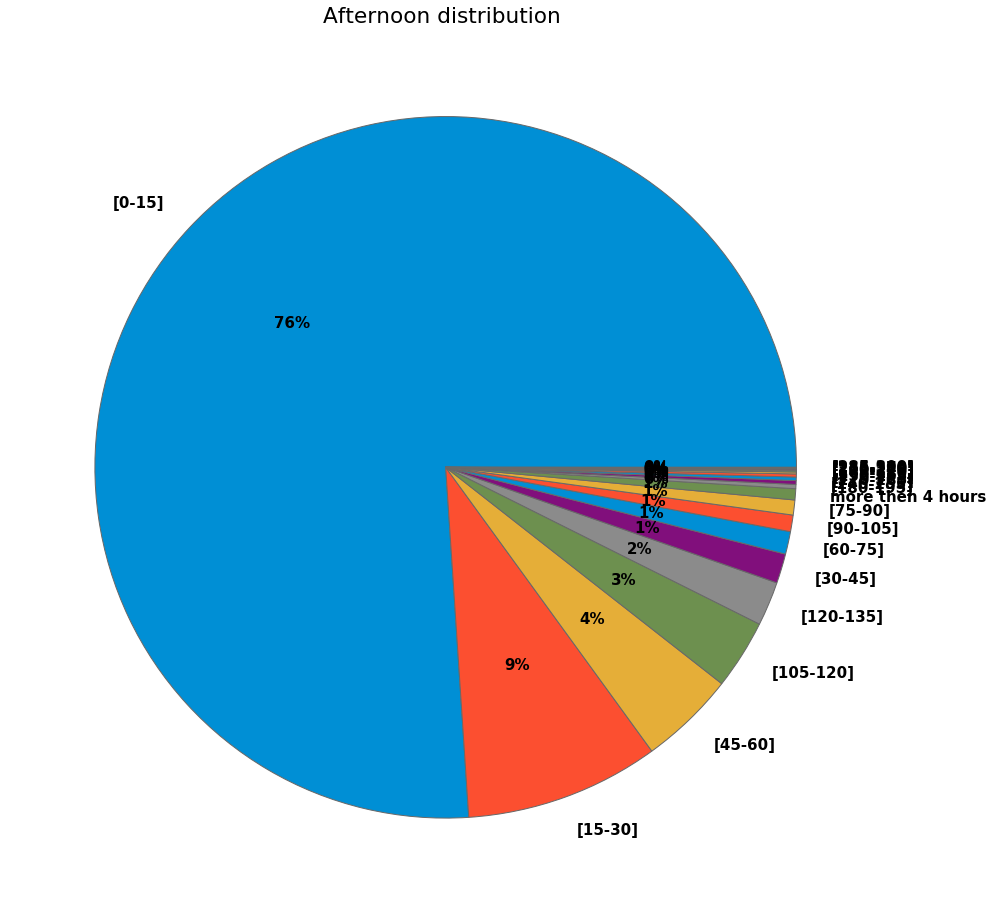

In [49]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch


fig_dim=(14,18)
f,ax=plt.subplots(figsize=fig_dim)
quality=pdf[pdf['part_of_day']=='afternoon']['delayLabel'].unique()
size=pdf[pdf['part_of_day']=='afternoon']['delayLabel'].value_counts()
plt.pie(size,labels=quality,autopct="%1.0f%%")
plt.title("Afternoon distribution ")
plt.show() 

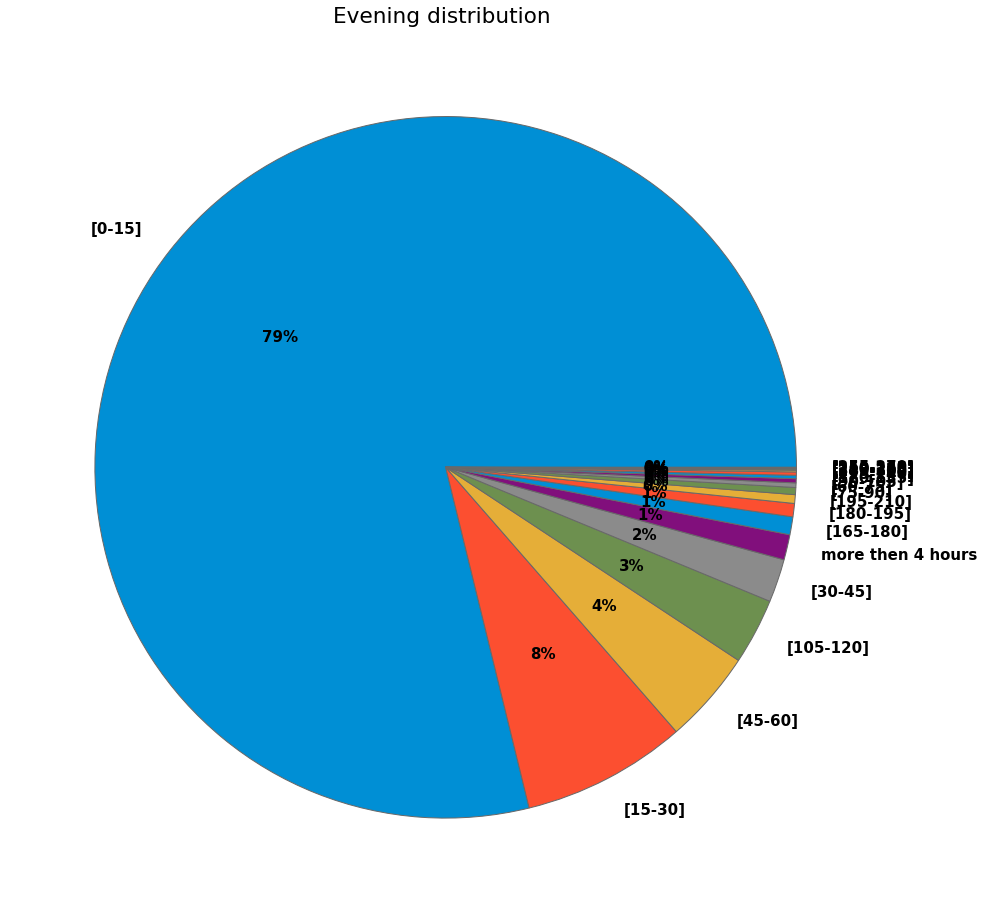

In [50]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch


fig_dim=(14,18)
f,ax=plt.subplots(figsize=fig_dim)
quality=pdf[pdf['part_of_day']=='evening']['delayLabel'].unique()
size=pdf[pdf['part_of_day']=='evening']['delayLabel'].value_counts()
plt.pie(size,labels=quality,autopct="%1.0f%%")
plt.title("Evening distribution ")
plt.show() 

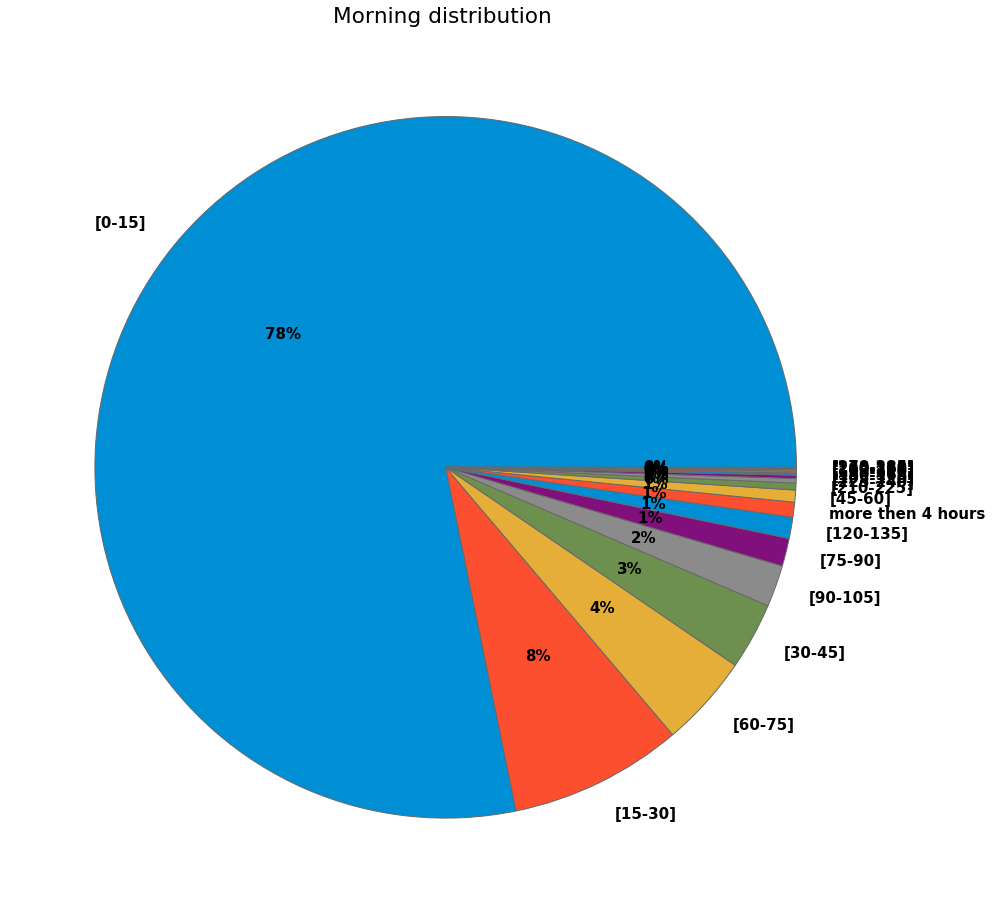

In [51]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch


fig_dim=(14,18)
f,ax=plt.subplots(figsize=fig_dim)
quality=pdf[pdf['part_of_day']=='morning']['delayLabel'].unique()
size=pdf[pdf['part_of_day']=='morning']['delayLabel'].value_counts()
plt.pie(size,labels=quality,autopct="%1.0f%%")
plt.title("Morning distribution ")
plt.show() 

In [52]:
import featuretools as ft


es = ft.EntitySet(id = 'flight')



In [53]:
es = es.entity_from_dataframe(entity_id = 'flight', dataframe = pdf,index="id_Flight")


2020-06-15 19:57:56,649 featuretools.entityset - WARNING    index id_Flight not found in dataframe, creating new integer column


In [54]:
es

Entityset: flight
  Entities:
    flight [Rows: 17556, Columns: 26]
  Relationships:
    No relationships

In [55]:
primitives = ft.list_primitives()
pd.options.display.max_colwidth = 100
primitives[primitives['type'] == 'aggregation'].head(100)

name         type  \
0                std  aggregation   
1              count  aggregation   
2             median  aggregation   
3      n_most_common  aggregation   
4           num_true  aggregation   
5              trend  aggregation   
6    time_since_last  aggregation   
7                max  aggregation   
8                any  aggregation   
9               mode  aggregation   
10  time_since_first  aggregation   
11             first  aggregation   
12           entropy  aggregation   
13               sum  aggregation   
14              skew  aggregation   
15  avg_time_between  aggregation   
16      percent_true  aggregation   
17        num_unique  aggregation   
18               all  aggregation   
19               min  aggregation   
20              last  aggregation   
21              mean  aggregation   

                                                                        description  
0               Computes the dispersion relative to the mean value, ignoring `NaN`.  
1                           Determines the total number of values, excluding `NaN`.  
2                             Determines the middlemost number in a list of values.  
3                                          Determines the `n` most common elements.  
4                                               Counts the number of `True` values.  
5                                     Calculates the trend of a variable over time.  
6         Calculates the time elapsed since the last datetime (default in seconds).  
7                              Calculates the highest value, ignoring `NaN` values.  
8                                      Determines if any value is 'True' in a list.  
9                                      Determines the most commonly repeated value.  
10               Calculates the time elapsed since the first datetime (in seconds).  
11                                            Determines the first value in a list.  
12                                Calculates the entropy for a categorical variable  
13                                   Calculates the total addition, ignoring `NaN`.  
14  Computes the extent to which a distribution differs from a normal distribution.  
15               Computes the average number of seconds between consecutive events.  
16                                         Determines the percent of `True` values.  
17                 Determines the number of distinct values, ignoring `NaN` values.  
18                                   Calculates if all values are 'True' in a list.  
19                            Calculates the smallest value, ignoring `NaN` values.  
20                                             Determines the last value in a list.  
21                                       Computes the average for a list of values.

In [56]:

primitives[primitives['type'] == 'transform'].head(1000)

name       type  \
22                             week  transform   
23          subtract_numeric_scalar  transform   
24                               or  transform   
25        less_than_equal_to_scalar  transform   
26                        longitude  transform   
27                           second  transform   
28                        less_than  transform   
29                           negate  transform   
30                       percentile  transform   
31                       time_since  transform   
32                              day  transform   
33                modulo_by_feature  transform   
34            greater_than_equal_to  transform   
35                             year  transform   
36                             isin  transform   
37                   num_characters  transform   
38                         absolute  transform   
39                       is_weekend  transform   
40                   modulo_numeric  transform   
41                     greater_than  transform   
42                 subtract_numeric  transform   
43              time_since_previous  transform   
44                          cum_max  transform   
45                   divide_numeric  transform   
46                      add_numeric  transform   
47                         cum_mean  transform   
48          multiply_numeric_scalar  transform   
49                        not_equal  transform   
50                          cum_sum  transform   
51  scalar_subtract_numeric_feature  transform   
52                            equal  transform   
53                        haversine  transform   
54                           minute  transform   
55                 less_than_scalar  transform   
56               less_than_equal_to  transform   
57                         latitude  transform   
58                              not  transform   
59                             hour  transform   
60                              and  transform   
61     greater_than_equal_to_scalar  transform   
62                             diff  transform   
63                        num_words  transform   
64            modulo_numeric_scalar  transform   
65              greater_than_scalar  transform   
66                            month  transform   
67                          weekday  transform   
68                          is_null  transform   
69            divide_numeric_scalar  transform   
70                divide_by_feature  transform   
71               add_numeric_scalar  transform   
72                          cum_min  transform   
73                 multiply_boolean  transform   
74                 not_equal_scalar  transform   
75                        cum_count  transform   
76                 multiply_numeric  transform   
77                     equal_scalar  transform   

                                                                    description  
22                             Determines the week of the year from a datetime.  
23                             Subtract a scalar from each element in the list.  
24                                        Element-wise logical OR of two lists.  
25               Determines if values are less than or equal to a given scalar.  
26                  Returns the second tuple value in a list of LatLong tuples.  
27                                  Determines the seconds value of a datetime.  
28                 Determines if values in one list are less than another list.  
29                                                     Negates a numeric value.  
30                     Determines the percentile rank for each value in a list.  
31                 Calculates time from a value to a specified cutoff datetime.  
32                             Determines the day of the month from a datetime.  
33                   Return the modulo of a scalar by each element in the list.  
34  Determines if values in one list are greater than or equal to another list.  
35                              

In [57]:
agg_primitives=primitives[primitives['type'] == 'aggregation']['name']
trans_primitives=primitives[primitives['type'] == 'transform']['name']

In [58]:
features, feature_names = ft.dfs(entityset = es, target_entity = 'flight', 
                                 agg_primitives = primitives[primitives['type'] == 'aggregation']['name'],
                                 trans_primitives = ['year', 'day', 'month', 'week','weekday','hour','is_weekend','minute','second'])

In [59]:
features

aircraft_aircrafttype_icaocode flightnumbers_icaoflightnumber  \
id_Flight                                                                 
0                                   A320                       EJU4459    
1                                   B737                       KLM1416    
2                                   A320                       EJU4353    
3                                   A319                       EJU4371    
4                                   A320                       AFR7643    
...                                  ...                            ...   
17551                               AT45                       CLG076     
17552                               B738                       DAH1139    
17553                               B748                       DAH1037    
17554                               B738                       DAH1461    
17555                               B738                       DAH1033    

          airportresources_terminal airports_destination_name  \
id_Flight                                                       
0                             T1                     Tenerife   
1                             T2                    Amsterdam   
2                             T1                       Nantes   
3                             T1            Berlin-Schonefeld   
4                             T2           Paris C. De Gaulle   
...                             ...                       ...   
17551                         T2                      Limoges   
17552                         T1                       Bejaia   
17553                         T1                        Alger   
17554                         T1                  Constantine   
17555                         T1                        Alger   

          airlines_airline_name airlines_operator_icaocode  \
id_Flight                                                    
0               Easy Jet Europe                        EJU   
1                           Klm                        KLM   
2               Easy Jet Europe                        EJU   
3               Easy Jet Europe                        EJU   
4                    Air France                        AFR   
...                         ...                        ...   
17551          Chalair Aviation                        CLG   
17552               Air Algerie                        DAH   
17553               Air Algerie                        DAH   
17554               Air Algerie                        DAH   
17555               Air Algerie                        DAH   

          airlines_airline_icaocode countrytype_code pression  \
id_Flight                                                       
0                               EJU                S   101100   
1                               KLM                S   101100   
2                               EJU                N   101100   
3                               EJU                S   101100   
4                               AFR                N   101200   
...                             ...              ...      ...   
17551                           CLG                N   101900   
17552                           DAH                I   100800   
17553                           DAH                I   100800   
17554                           DAH                I   100800   
17555                           DAH                I   100900   

          direction_de_vent vitesse_de_vent temperature humidité visibilité  \
id_Flight                                                                     
0                       310            10.8      279.68       45      10000   
1                       310            10.8      279.68       45      10000   
2                       310            10.8      279.68       45      10000   
3                       310            10.8      279.68       45      10000   
4                       300             9.3      279.75      

In [60]:
features[['MONTH(timestamps_sobt)','delay']].groupby('MONTH(timestamps_sobt)').mean()

delay
MONTH(timestamps_sobt)           
1                       15.258300
2                       16.536301
3                       13.035820
4                        0.458678
5                       19.299213
6                       11.654545

In [61]:
features[['WEEKDAY(timestamps_sobt)','delay']].groupby('WEEKDAY(timestamps_sobt)').mean()

delay
WEEKDAY(timestamps_sobt)           
0                         11.524409
1                          9.099309
2                          8.448685
3                         17.559110
4                         18.268031
5                         20.731878
6                         15.015398

In [62]:
features[['IS_WEEKEND(timestamps_sobt)','delay']].groupby('IS_WEEKEND(timestamps_sobt)').mean()

delay
IS_WEEKEND(timestamps_sobt)           
False                        13.627321
True                         17.843993

In [63]:
features[['MONTH(timestamps_sobt)','DAY(timestamps_sobt)','delay']].groupby(['MONTH(timestamps_sobt)','DAY(timestamps_sobt)']).mean()

delay
MONTH(timestamps_sobt) DAY(timestamps_sobt)           
1                      20                     4.993151
                       21                     7.763265
                       22                     6.062257
                       23                    22.302521
                       24                    31.702403
...                                                ...
6                      9                      1.454545
                       10                     1.666667
                       11                     0.916667
                       12                     3.000000
                       13                    12.666667

[124 rows x 1 columns]

In [64]:
global_stats

min     max   count       mean
airlines_airline_icaocode                                
XXX                        0.0     0.0     1.0   0.000000
None                       0.0     0.0     1.0   0.000000
OHY                        0.0     0.0     1.0   0.000000
FHY                        0.0     0.0     1.0   0.000000
RBG                        0.0     0.0     1.0   0.000000
...                        ...     ...     ...        ...
BAW                        0.0   124.0   581.0  11.820998
DAH                        0.0   475.0   889.0  30.133858
DLH                        0.0   132.0  1054.0   5.759013
EJU                        0.0   260.0  2774.0  16.969358
AFR                        0.0  1438.0  5992.0  11.650033

[74 rows x 4 columns]

In [65]:
global_stats.sort_values(by='mean', ascending=True).head(10)

min  max  count  mean
airlines_airline_icaocode                       
XXX                        0.0  0.0    1.0   0.0
None                       0.0  0.0    1.0   0.0
OHY                        0.0  0.0    1.0   0.0
FHY                        0.0  0.0    1.0   0.0
RBG                        0.0  0.0    1.0   0.0
TRA                        0.0  0.0    1.0   0.0
ELF                        0.0  0.0    4.0   0.0
LMU                        0.0  0.0    7.0   0.0
RLU                        0.0  0.0    2.0   0.0
JAF                        0.0  4.0    8.0   0.5

In [66]:
pdf.columns

Index(['id_Flight', 'aircraft_aircrafttype_icaocode',
       'flightnumbers_icaoflightnumber', 'airportresources_terminal',
       'airports_destination_name', 'airlines_airline_name',
       'airlines_operator_icaocode', 'airlines_airline_icaocode',
       'countrytype_code', 'timestamps_sobt', 'timestamps_eobt', 'pression',
       'direction_de_vent', 'vitesse_de_vent', 'temperature', 'humidité',
       'visibilité', 'nebulosite', 'hauteur_neige', 'datedepart', 'pays',
       'date_obs', 'confirmed', 'part_of_day', 'delay', 'delayLabel'],
      dtype='object')

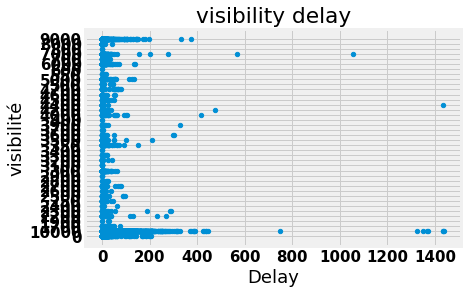

In [67]:
import numpy as np
import matplotlib.pyplot as plt


colors = (0,0,0)
area = np.pi*6


# Plot
plt.scatter(pdf["delay"],pdf.sort_values(by='visibilité', ascending=True)["visibilité"] , s=area, alpha=1)
plt.title('visibility delay')
plt.xlabel('Delay')
plt.ylabel('visibilité')
plt.show()

In [68]:
pdf.sort_values(by='visibilité', ascending=True)["visibilité"]

17555       0
3413        0
3412        0
3411        0
3410        0
         ... 
3558     9000
3557     9000
3556     9000
5407     9000
16092    9000
Name: visibilité, Length: 17556, dtype: object

In [69]:
pdf=pdf.astype({'pression': 'float64'})
pdf=pdf.astype({'direction_de_vent': 'float64'})
pdf=pdf.astype({'vitesse_de_vent': 'float64'})

pdf=pdf.astype({'temperature': 'float64'})
pdf=pdf.astype({'humidité': 'float64'})
pdf=pdf.astype({'visibilité': 'float64'})
pdf=pdf.astype({'hauteur_neige': 'float64'})
pdf=pdf.astype({'nebulosite': 'float64'})

pdf=pdf.drop(['timestamps_eobt'], axis=1)

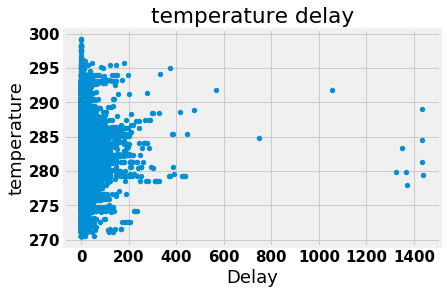

In [70]:
import numpy as np
import matplotlib.pyplot as plt


colors = (0,0,0)
area = np.pi*6


# Plot
plt.scatter(pdf["delay"],pdf.sort_values(by='temperature', ascending=True)["temperature"] , s=area, alpha=1)
plt.title('temperature delay')
plt.xlabel('Delay')
plt.ylabel('temperature')
plt.show()

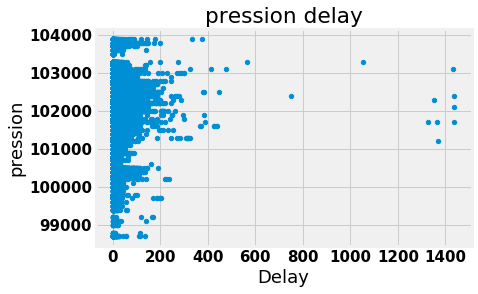

In [71]:
import numpy as np
import matplotlib.pyplot as plt


colors = (0,0,0)
area = np.pi*6


# Plot
plt.scatter(pdf["delay"],pdf.sort_values(by='pression', ascending=True)["pression"] , s=area, alpha=1)
plt.title('pression delay')
plt.xlabel('Delay')
plt.ylabel('pression')
plt.show()

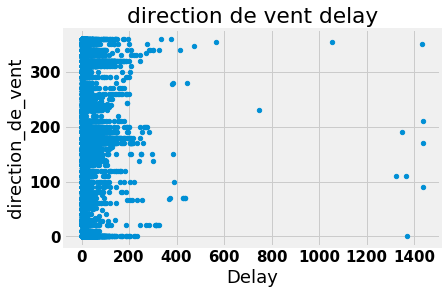

In [72]:
import numpy as np
import matplotlib.pyplot as plt


colors = (0,0,0)
area = np.pi*6


# Plot
plt.scatter(pdf["delay"],pdf.sort_values(by='direction_de_vent', ascending=True)["direction_de_vent"] , s=area, alpha=1)
plt.title('direction de vent delay')
plt.xlabel('Delay')
plt.ylabel('direction_de_vent')
plt.show()

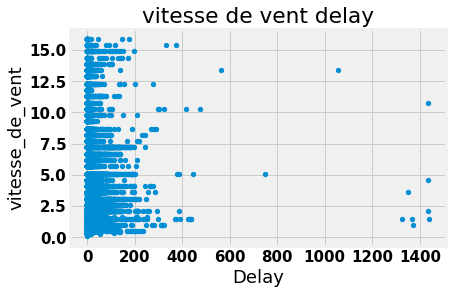

In [73]:

import numpy as np
import matplotlib.pyplot as plt


colors = (0,0,0)
area = np.pi*6


# Plot
plt.scatter(pdf["delay"],pdf.sort_values(by='vitesse_de_vent', ascending=True)["vitesse_de_vent"] , s=area, alpha=1)
plt.title('vitesse de vent delay')
plt.xlabel('Delay')
plt.ylabel('vitesse_de_vent')
plt.show()

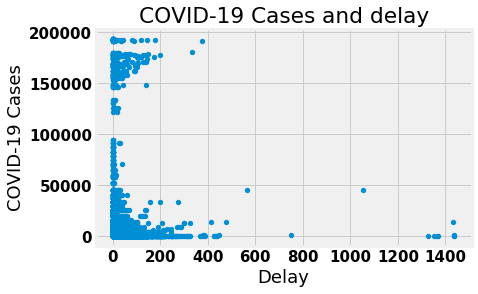

In [74]:
import numpy as np
import matplotlib.pyplot as plt


colors = (0,0,0)
area = np.pi*6


# Plot
plt.scatter(pdf["delay"],pdf.sort_values(by='confirmed', ascending=True)["confirmed"] , s=area, alpha=1)
plt.title('COVID-19 Cases and delay')
plt.xlabel('Delay')
plt.ylabel('COVID-19 Cases')
plt.show()

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.ticker as ticker
%matplotlib inline 

# Section 2 - Loading and Selecting Data
df1 = pd.read_csv('https://raw.githubusercontent.com/datasets/covid-19/master/data/countries-aggregated.csv', parse_dates=['Date'])
countries = ['Canada', 'Germany', 'United Kingdom', 'US', 'France', 'China']

df1 = df1[df1['Country'].isin(countries)]

# Section 3 - Creating a Summary Column
df1['Cases'] = df1[['Confirmed', 'Recovered', 'Deaths']].sum(axis=1)

In [76]:
df1

Date         Country  Confirmed  Recovered  Deaths    Cases
32    2020-01-22          Canada          0          0       0        0
36    2020-01-22           China        548         28      17      593
62    2020-01-22          France          0          0       0        0
66    2020-01-22         Germany          0          0       0        0
174   2020-01-22              US          1          0       0        1
...          ...             ...        ...        ...     ...      ...
27108 2020-06-14           China      84335      79482    4638   168455
27134 2020-06-14          France     194153      72982   29410   296545
27138 2020-06-14         Germany     187518     172089    8801   368408
27246 2020-06-14              US    2094058     561816  115732  2771606
27250 2020-06-14  United Kingdom     297342       1283   41783   340408

[870 rows x 6 columns]

In [77]:
df1 = df1[df1['Country']=='France'].pivot(index='Date', columns='Country', values='Cases')
countries = list(df.columns)
covid = df1.reset_index('Date')
covid.set_index(['Date'], inplace=True)


# Section 5 - Calculating Rates per 100,000
populations = {'Canada':37664517, 'Germany': 83721496 , 'United Kingdom': 67802690 , 'US': 330548815, 'France': 65239883, 'China':1438027228}
percapita = covid.copy()
for country in list(percapita.columns):
    percapita[country] = percapita[country]/populations[country]*100000

In [78]:
covid

Country     France
Date              
2020-01-22       0
2020-01-23       0
2020-01-24       2
2020-01-25       3
2020-01-26       3
...            ...
2020-06-10  293342
2020-06-11  294111
2020-06-12  295292
2020-06-13  296078
2020-06-14  296545

[145 rows x 1 columns]

Text(2020-01-23 00:00:00, 341545, 'COVID-19 Cases by france')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


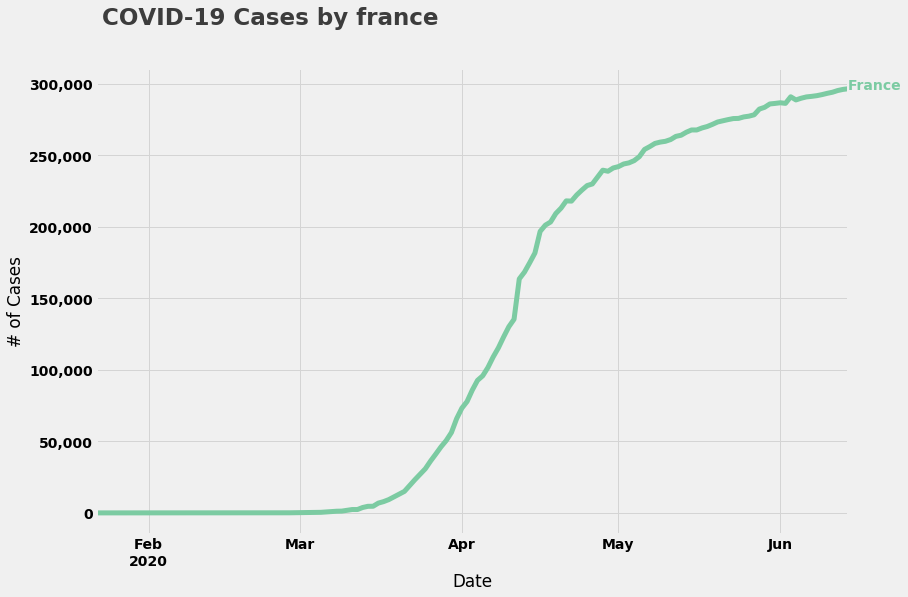

In [79]:
# Section 6 - Generating Colours and Style
colors = {'France':'#7CCBA2'}
plt.style.use('fivethirtyeight')

# Section 7 - Creating the Visualization
plot = covid.plot(figsize=(12,8), color=list(colors.values()), linewidth=5, legend=False)
plot.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plot.grid(color='#d4d4d4')
plot.set_xlabel('Date')
plot.set_ylabel('# of Cases')

# Section 8 - Assigning Colour
for country in list(colors.keys()):
    plot.text(x = covid.index[-1], y = covid[country].max(), color = colors[country], s = country, weight = 'bold')

# Section 9 - Adding Labels
plot.text(x = covid.index[1], y = int(covid.max().max())+45000, s = "COVID-19 Cases by france", fontsize = 23, weight = 'bold', alpha = .75)


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


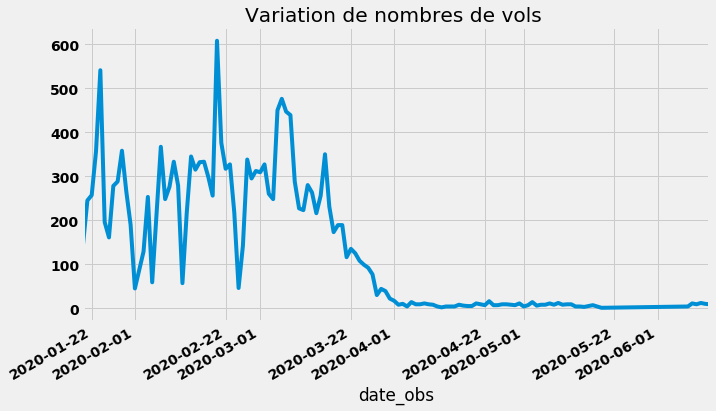

In [80]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch



groups_labels = pdf.groupby(['date_obs']).size()
plt.title('Variation de nombres de vols ')
d=groups_labels.to_frame()
groups_labels.plot(y=0, use_index=True,figsize=(10,6))